<a href="https://colab.research.google.com/github/rambasnet/DeepLearningMaliciousURLs/blob/master/Keras-Tensorflow-Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras-Theano Experiments

## Import libraries

In [35]:
! pip install seaborn

     |████████████████████████████████| 215kB 446kB/s eta 0:00:01


In [36]:
from __future__ import absolute_import, division, print_function, unicode_literals

import shutil
import numpy as np
import pandas as pd
import tensorflow as tf

import csv
import os
import sys
import glob
import operator
import time
from timeit import default_timer as timer
import datetime

import matplotlib.pyplot as plt
import seaborn as sn

from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical, normalize

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import TensorBoard
from keras import backend as K

print(tf.__version__)
print(K.backend())
assert K.backend() == 'theano', 'set backend to theano in ~/.keras/keras.json file'

1.14.1-dev20190529
theano


### Check Dataset
- if FinalDataset folder is not found, run bash script in Baseline-Experiments.ipynb

In [2]:
! ls FinalDataset

All.csv                      Malware_Infogain.csv
All.csv.pickle               Malware_Infogain_test.csv
All.csvDroppedNaNCols.pickle Phishing.csv
All_BestFirst.csv            Phishing_BestFirst.csv
All_BestFirst_test.csv       Phishing_Infogain.csv
All_Infogain.csv             Phishing_Infogain_test.csv
All_Infogain_test.csv        Spam.csv
Defacement.csv               Spam_BestFirst.csv
Defacement_BestFirst.csv     Spam_BestFirst_test.csv
Defacement_Infogain.csv      Spam_Infogain.csv
Defacement_Infogain_test.csv Spam_Infogain_test.csv
Malware.csv                  URL
Malware_BestFirst.csv        models


### Set path to store results

In [3]:
resultPath = 'results_keras_theano'
if not os.path.exists(resultPath):
   print('result path {} created.'.format(resultPath))
   os.mkdir(resultPath)

In [4]:
model_name = "init"

## Load cleaned data
- if All.csvDroppedNaNCols.pickle file doesn't exist in FinalDataset folder, run loadAndCleanData(csvFile) function in Baseline-Experiments-DroppedColumns.pynb

In [5]:
dataset = 'All.csv'
pickleDump = os.path.join('FinalDataset', '{}DroppedNaNCols.pickle'.format(dataset))
df = pd.read_pickle(pickleDump)

In [61]:
def baseline_model(inputDim=-1,outputDim=-1):
    global model_extension, experimentTitle
    model = tf.keras.Sequential([
        Dense(inputDim, activation='relu', input_shape=(inputDim,)),
        BatchNormalization(),
        Dropout(.5),
        Dense(inputDim//2, activation='relu'),
        BatchNormalization(),
        Dropout(.5),
        Dense(outputDim, activation='softmax')
    ]) #This is the output layer

    if outputDim > 2:
        print('Categorical Cross-Entropy Loss Function')
        model_extension = "_categorical"
        experimentTitle = "Categorical"
        model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    else:
        print('Binary Cross-Entropy Loss Function')
        model_extension = "_binary"
        experimentTitle = "Binary"
        model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

    return model

In [7]:
# Split-out validation dataset
def splitDataset(df):
    array = df.values
    # last attribute/column is label
    labelIndex = len(df.columns)-1
    X = array[:,0:labelIndex]
    Y = array[:,labelIndex]
    validation_size = 0.20
    random_seed = 100
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, 
                                                                    test_size=validation_size, 
                                                                    random_state=random_seed)
    return X_train, X_validation, Y_train, Y_validation
    

In [8]:
def encode_labels(dataframe):
    dataframe = dataframe.copy()
    data_y=dataframe.pop(dep_var)
    encoder = LabelEncoder()
    encoder.fit(data_y)
    data_y = encoder.transform(data_y)
    dummy_y = to_categorical(data_y)
    return dummy_y

In [9]:
def plotAccuracy(title):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [10]:
def plotLoss(title):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [70]:
def plot_Experiment(history, y):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    plt.ylim([0,y])
    plt.legend()

    plt.show()

## Create and train Theano Model

In [20]:
# Function to determine train and validation indexes, 
# and fit the data to the model we constructed
def trainModel(train_X, train_Y, early_stop=False):
    random_seed = 10
    epochs = 100
    batch_size = 64
    dep_var = label
    dataFile = 'All.csv'
    #10-fold cross validation, choosing random indices for training and validation
    # KFolotS
    sss = StratifiedShuffleSplit(n_splits=1, random_state=random_seed)
    
    # X is our data/features to train the model with
    X = StandardScaler().fit_transform(train_X)
    
    # Y is our labels to classify the data
    encoder = LabelEncoder()
    encoder.fit(train_Y)
    Y = encoder.transform(train_Y)
    Y = to_categorical(Y) # one-hot encoding
    #print(Y)
    start_time = timer()
    results = []
    fold = 1
    for train_indices, val_indices in sss.split(X, Y):
        
        xtrain, xval = X[train_indices], X[val_indices]
        ytrain, yval = Y[train_indices], Y[val_indices]
        #print(xtrain.shape)
        #print(len(set(train_Y)))
        inputDim = xtrain.shape[1]
        outputDim = len(set(train_Y))
        print("Running fold # {}".format(fold))
        fold += 1

        model = baseline_model(inputDim, outputDim)
        
        time_gen = int(time.time())
        
        global model_name
        model_name = f"{dataFile}_{time_gen}"

        tensorboard = TensorBoard(log_dir='keras_theano_logs/{}/{}_{}'.format(experimentTitle, model_name, model_extension),update_freq='epoch')
        if early_stop:
            callbacks = [tensorboard, early_stop]
        else:
            callbacks = [tensorboard]
        history = model.fit(xtrain, ytrain, epochs=epochs, validation_data=(xval, yval), callbacks=callbacks, batch_size=100, verbose=0)
        results.append(history)
         
    elapsed_time = timer() - start_time
    TimeSetup = str(datetime.timedelta(seconds=elapsed_time))
    print("Time to complete {} [hour:min:sec]".format(TimeSetup))   
    return model, history, TimeSetup


  ## Multi-class classification
  
  #### Total Samples for each Type

In [21]:
label = 'URL_Type_obf_Type'
lblTypes=set(df[label])
for lbl in lblTypes:
    print('| {} | {} |'.format(lbl, len(df[df[label] == lbl].index)))

| benign | 7781 |
| spam | 6698 |
| Defacement | 7930 |
| malware | 6711 |
| phishing | 7577 |


In [22]:
df.shape

(36697, 73)

In [23]:
X_train, X_validation, Y_train, Y_validation = splitDataset(df)
model, history, TimeSetup = trainModel(X_train, Y_train)

Running fold # 1
Categorical Cross-Entropy Loss Function
Time to complete 0:01:25.254654 [hour:min:sec]


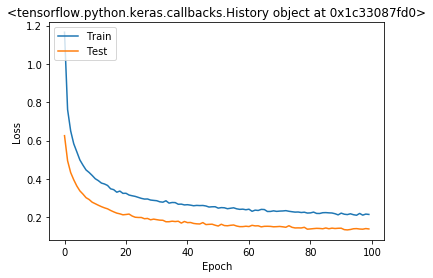

In [73]:
plotLoss(history)

#### Graph of Categorical Cross-Entropy Model

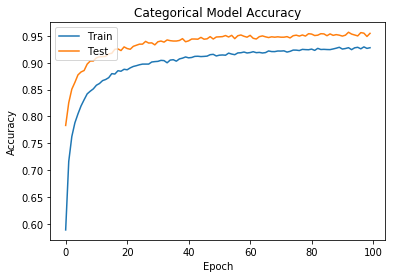

In [69]:
plotAccuracy('Categorical Model Accuracy')

## Test our model using hold-out validation set

In [26]:
prediction_y = model.predict_classes(X_validation, batch_size=100, verbose=1)

7340/7340 [==============================] - 0s 40us/sample


In [32]:
print(prediction_y)

[3 3 3 ... 3 3 3]


#### Confusion Matrix

[2 0 3 ... 0 3 1]


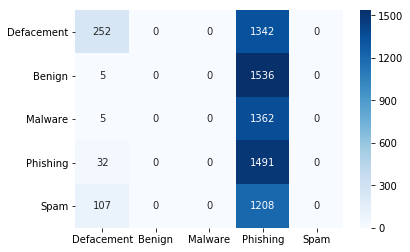

In [37]:
y=LabelEncoder().fit_transform(Y_validation)
print(y)
cm = confusion_matrix(y, prediction_y)
sn.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Defacement','Benign','Malware','Phishing','Spam'],
           yticklabels=['Defacement','Benign','Malware','Phishing','Spam'])

[0 1 4 ... 0 1 1]
Categorical Cross-Entropy Loss Function
Train on 29357 samples
Epoch 1/10
29357/29357 [==============================] - 3s 115us/sample - loss: 1.1371 - acc: 0.5845
Epoch 2/10
29357/29357 [==============================] - 3s 91us/sample - loss: 0.7921 - acc: 0.7117
Epoch 3/10
29357/29357 [==============================] - 2s 81us/sample - loss: 0.6849 - acc: 0.7556
Epoch 4/10
29357/29357 [==============================] - 2s 83us/sample - loss: 0.6276 - acc: 0.7793
Epoch 5/10
29357/29357 [==============================] - 3s 87us/sample - loss: 0.5909 - acc: 0.7900
Epoch 6/10
29357/29357 [==============================] - 2s 84us/sample - loss: 0.5618 - acc: 0.8002
Epoch 7/10
29357/29357 [==============================] - 2s 80us/sample - loss: 0.5366 - acc: 0.8099
Epoch 8/10
29357/29357 [==============================] - 2s 84us/sample - loss: 0.5243 - acc: 0.8151
Epoch 9/10
29357/29357 [==============================] - 3s 89us/sample - loss: 0.5060 - acc: 0.8205


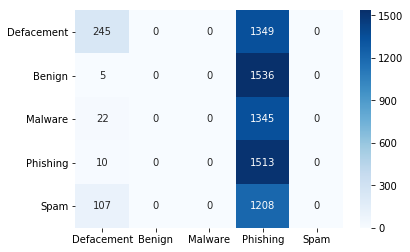

In [62]:
# X is our data/features to train the model with
X = StandardScaler().fit_transform(X_train)
epochs = 100
# Y is our labels to classify the data
encoder = LabelEncoder()
encoder.fit(Y_train)
Y = encoder.transform(Y_train)
print(Y)
Y = to_categorical(Y) # one-hot encoding
inputDim = X_train.shape[1]
outputDim = len(set(Y_train))

actual_Y = LabelEncoder().fit_transform(Y_validation)

model = baseline_model(inputDim, outputDim)
result = model.fit(X, Y, epochs=10)
predicted_Y = model.predict_classes(X_validation, batch_size=100, verbose=1)
score = model.evaluate(X_validation, to_categorical(actual_Y), batch_size=128)
print(score)
cm = confusion_matrix(actual_Y, predicted_Y)
print(cm)
sn.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Defacement','Benign','Malware','Phishing','Spam'],
       yticklabels=['Defacement','Benign','Malware','Phishing','Spam'])   
    
    

In [56]:
print(actual_Y)

[2 0 3 ... 0 3 1]


LabelEncoder()


In [43]:
holdOutExperiment(X_train, Y_train, X_validation, Y_validation)

Categorical Cross-Entropy Loss Function
Train on 29357 samples
Epoch 1/100
29357/29357 [==============================] - 3s 97us/sample - loss: 0.9543 - acc: 0.6488
Epoch 2/100
29357/29357 [==============================] - 2s 81us/sample - loss: 0.6589 - acc: 0.7573
Epoch 3/100
29357/29357 [==============================] - 3s 92us/sample - loss: 0.5685 - acc: 0.7930
Epoch 4/100
29357/29357 [==============================] - 3s 89us/sample - loss: 0.5135 - acc: 0.8147
Epoch 5/100
29357/29357 [==============================] - 2s 79us/sample - loss: 0.4846 - acc: 0.8252
Epoch 6/100
29357/29357 [==============================] - 2s 81us/sample - loss: 0.4524 - acc: 0.8382
Epoch 7/100
29357/29357 [==============================] - 3s 88us/sample - loss: 0.4337 - acc: 0.8460
Epoch 8/100
29357/29357 [==============================] - 3s 88us/sample - loss: 0.4294 - acc: 0.8469
Epoch 9/100
29357/29357 [==============================] - 2s 84us/sample - loss: 0.4084 - acc: 0.8547
Epoch 10/1

Epoch 78/100
29357/29357 [==============================] - 2s 79us/sample - loss: 0.2586 - acc: 0.9111
Epoch 79/100
29357/29357 [==============================] - 2s 74us/sample - loss: 0.2608 - acc: 0.9111
Epoch 80/100
29357/29357 [==============================] - 2s 77us/sample - loss: 0.2592 - acc: 0.9132
Epoch 81/100
29357/29357 [==============================] - 2s 77us/sample - loss: 0.2579 - acc: 0.9123
Epoch 82/100
29357/29357 [==============================] - 2s 77us/sample - loss: 0.2605 - acc: 0.9102
Epoch 83/100
29357/29357 [==============================] - 2s 79us/sample - loss: 0.2567 - acc: 0.9136
Epoch 84/100
29357/29357 [==============================] - 2s 80us/sample - loss: 0.2547 - acc: 0.9143
Epoch 85/100
29357/29357 [==============================] - 2s 77us/sample - loss: 0.2569 - acc: 0.9108
Epoch 86/100
29357/29357 [==============================] - 2s 75us/sample - loss: 0.2531 - acc: 0.9138
Epoch 87/100
29357/29357 [==============================] - 2s 7

NameError: name 'acutal_Y' is not defined

7340/7340 [==============================] - 0s 21us/sample
[[ 252    0    0 1342    0]
 [   5    0    0 1536    0]
 [   5    0    0 1362    0]
 [  32    0    0 1491    0]
 [ 107    0    0 1208    0]]


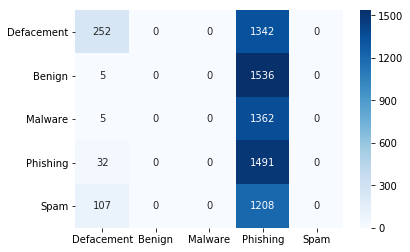

In [48]:
predicted_Y = model.predict_classes(X_validation, batch_size=100, verbose=1)
actual_Y = LabelEncoder().fit_transform(Y_validation)
cm = confusion_matrix(actual_Y, predicted_Y)
print(cm)
sn.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Defacement','Benign','Malware','Phishing','Spam'],
       yticklabels=['Defacement','Benign','Malware','Phishing','Spam'])  

### Write results to file

In [0]:

def saveLog():
    resultFile = os.path.join(resultPath, dataFile)
    with open('{}.result'.format(resultFile), 'a') as fout:
        fout.write('{} results...'.format(model_name+model_extension))
        fout.write('\taccuracy: {:.2f} loss: {:.2f} time_elapsed: {} [hr:min:sec] \n'.format(acc, loss,tTime ))

In [0]:
saveLog()

## Binary Classification of Labels
> Change all malicious labels to value 1 and benign label to 0

### Binarize Data

In [0]:
lblTypes = list(lblTypes)
lblTypes = dict(zip(lblTypes, [1, 1, 1, 1, 1]))
lblTypes['benign'] = 0

In [0]:
binary_df = df1.copy()
binary_df[label] = binary_df[label].map(lblTypes)

### Train the Binary Model

In [122]:
model, history, X , encoded_y, tTime = experiment(binary_df)

Running fold #1


W0731 01:50:57.923707 140023254493056 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Binary Cross-Entropy Loss Function
Running fold #2
Binary Cross-Entropy Loss Function
Running fold #3
Binary Cross-Entropy Loss Function
Running fold #4
Binary Cross-Entropy Loss Function
Running fold #5
Binary Cross-Entropy Loss Function
Running fold #6
Binary Cross-Entropy Loss Function
Running fold #7
Binary Cross-Entropy Loss Function
Running fold #8
Binary Cross-Entropy Loss Function
Running fold #9
Binary Cross-Entropy Loss Function
Running fold #10
Binary Cross-Entropy Loss Function
Time to complete 0:25:22.330827 [hour:min:sec]


### Model Results

In [123]:
scores = model.evaluate(X,encoded_y, verbose=1)
print(model.metrics_names)
acc, loss = scores[1]*100, scores[0]
print('Baseline: accuracy: {:.2f}%: loss: {:.2f}'.format(acc, loss))

36697/36697 [==============================] - 4s 115us/sample - loss: 0.0441 - acc: 0.9862
['loss', 'acc']
Baseline: accuracy: 98.62%: loss: 0.04


#### Predictions

In [124]:
prediction_y = model.predict_classes(X, batch_size=batch_size, verbose=1)

36697/36697 [==============================] - 4s 106us/sample


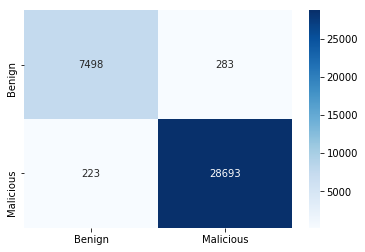

In [125]:
y=LabelEncoder().fit_transform(binary_df[dep_var].values)
cm = confusion_matrix(y, prediction_y)
sn.heatmap(cm, cmap='Blues', annot=True, fmt='g', xticklabels=['Benign', 'Malicious'],
        yticklabels=['Benign', 'Malicious'])

#### Graph of Binary Cross-Entropy Model

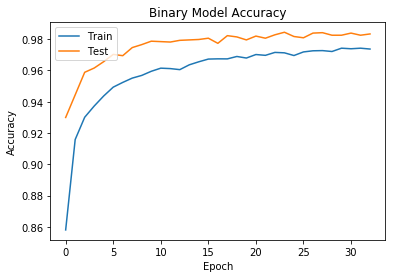

In [126]:
plotAccuracy('Binary Model Accuracy')

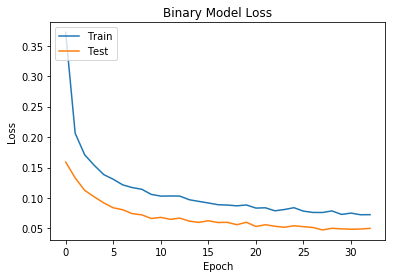

In [127]:
plotLoss('Binary Model Loss')

### Write Results to File

In [0]:
saveLog()